In [1]:
import numpy as np
import pandas as pd
import seaborn as sns;sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import math
from math import sqrt

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image

from sklearn import neighbors
import itertools
import plotly.express as px

from itertools import chain
from matplotlib.pyplot import figure

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score

from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from collections import Counter

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize
import re
import string

pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [2]:
df=pd.read_csv('train.txt',delimiter=";",header=None,names=['corpus','feeling'])

In [3]:
df

,corpus,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
df.feeling.value_counts(normalize=True)

joy        0.33513
sadness    0.29163
anger      0.13494
fear       0.12106
love       0.08150
surprise   0.03575
Name: feeling, dtype: float64

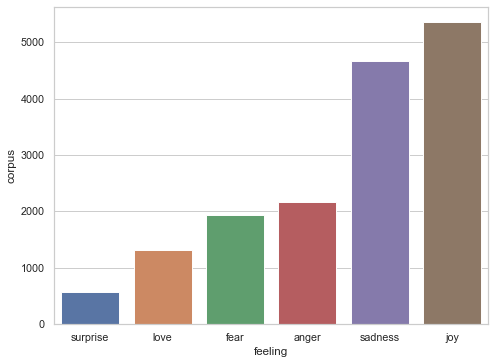

In [5]:

result=df.groupby(by="feeling").count().sort_values(by=['corpus']).reset_index()
fig=figure(figsize=(8, 6), dpi=70)
sns.barplot(x='feeling', y="corpus", data=result, order=result['feeling'])
plt.show()

### Instancio un modelo solo para probar "hipotesis nula"

In [7]:
CountVectorizer().get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'preprocessor', 'stop_words', 'strip_accents', 'token_pattern', 'tokenizer', 'vocabulary'])

In [8]:
TfidfTransformer().get_params().keys()

dict_keys(['norm', 'smooth_idf', 'sublinear_tf', 'use_idf'])

In [9]:
MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [10]:
TfidfVectorizer().get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [11]:
#Agrego las mismas palabras de las stop words pero sin apostrofes (ej: haven't, agrego havent)
stop_words=stopwords.words('english');

hifen =' '.join(stop_words)
hifen = re.sub("'", '', hifen)    
hifen=word_tokenize(hifen)

stop_words.extend(hifen)

In [ ]:
df.feeling.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [13]:
#Veo las palabras más frecuentes por feeling
clases=['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'];

params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': 'english',
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

most_common=[]

for clase in clases:
    X=vectorizer.fit_transform(df[df['feeling']==clase]['corpus']);
    counts=X.sum(axis=0);
    counts=np.array(counts);
    
    indices=np.argsort(counts);
    valores=np.sort(counts);
    indices=indices[0][::-1];
    valores=valores[0][::-1];
    terms=np.array(vectorizer.get_feature_names_out());
    most_common.append(terms[indices[:20]])

    print('\n Clase ',clase)
    print(terms[indices[:20]])


 Clase  sadness
['feel' 'feeling' 'like' 'im' 'feel like' 'just' 'im feeling' 'really'
 'know' 'little' 'time' 'ive' 'bit' 'want' 'think' 'life' 'people' 'bad'
 'pretty' 'sorry']

 Clase  anger
['feel' 'feeling' 'like' 'im' 'feel like' 'just' 'im feeling' 'irritable'
 'really' 'cold' 'angry' 'fucked' 'agitated' 'greedy' 'pissed' 'wronged'
 'irritated' 'little' 'insulted' 'know']

 Clase  love
['feel' 'feeling' 'like' 'feel like' 'im' 'loving' 'sympathetic' 'hot'
 'horny' 'passionate' 'accepted' 'blessed' 'love' 'im feeling' 'caring'
 'just' 'fond' 'loved' 'sweet' 'delicate']

 Clase  surprise
['feel' 'feeling' 'overwhelmed' 'im' 'weird' 'impressed' 'amazed' 'funny'
 'curious' 'shocked' 'strange' 'surprised' 'like' 'feel funny' 'just'
 'feel amazed' 'feel weird' 'feeling overwhelmed' 'im feeling' 'amazing']

 Clase  fear
['feel' 'feeling' 'im' 'like' 'im feeling' 'little' 'just' 'feel like'
 'bit' 'anxious' 'vulnerable' 'strange' 'insecure' 'weird' 'terrified'
 'know' 'nervous' 'afraid

In [14]:
new_stop_words=list(chain(*most_common))

In [15]:
#Veo las palabras más repetidas de las palabras más frecuentes por feeling
Counter(new_stop_words).most_common()

[('feel', 6),
 ('feeling', 6),
 ('like', 6),
 ('im', 6),
 ('just', 6),
 ('im feeling', 6),
 ('feel like', 5),
 ('know', 4),
 ('little', 4),
 ('really', 3),
 ('time', 2),
 ('bit', 2),
 ('want', 2),
 ('think', 2),
 ('life', 2),
 ('people', 2),
 ('pretty', 2),
 ('love', 2),
 ('weird', 2),
 ('strange', 2),
 ('ive', 1),
 ('bad', 1),
 ('sorry', 1),
 ('irritable', 1),
 ('cold', 1),
 ('angry', 1),
 ('fucked', 1),
 ('agitated', 1),
 ('greedy', 1),
 ('pissed', 1),
 ('wronged', 1),
 ('irritated', 1),
 ('insulted', 1),
 ('loving', 1),
 ('sympathetic', 1),
 ('hot', 1),
 ('horny', 1),
 ('passionate', 1),
 ('accepted', 1),
 ('blessed', 1),
 ('caring', 1),
 ('fond', 1),
 ('loved', 1),
 ('sweet', 1),
 ('delicate', 1),
 ('overwhelmed', 1),
 ('impressed', 1),
 ('amazed', 1),
 ('funny', 1),
 ('curious', 1),
 ('shocked', 1),
 ('surprised', 1),
 ('feel funny', 1),
 ('feel amazed', 1),
 ('feel weird', 1),
 ('feeling overwhelmed', 1),
 ('amazing', 1),
 ('anxious', 1),
 ('vulnerable', 1),
 ('insecure', 1),
 ('

In [16]:
# If more than 2 of the feelings have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(new_stop_words).most_common() if count > 2]
add_stop_words

['feel',
 'feeling',
 'like',
 'im',
 'just',
 'im feeling',
 'feel like',
 'know',
 'little',
 'really']

In [17]:
#Agrego palabras adicionales
stop_words.extend(add_stop_words)
stop_words.append('ive')
stop_words.append('feels')
stop_words.append('get')
stop_words.append('would')

In [18]:
#Segunda limpieza

clases=['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'];

params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': stop_words,
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

for clase in clases:
    X=vectorizer.fit_transform(df[df['feeling']==clase]['corpus']);
    counts=X.sum(axis=0);
    counts=np.array(counts);
    
    indices=np.argsort(counts);
    valores=np.sort(counts);
    indices=indices[0][::-1];
    valores=valores[0][::-1];
    terms=np.array(vectorizer.get_feature_names_out());

    print('\n Clase ',clase)
    print(terms[indices[:20]])


 Clase  sadness
['still' 'alone' 'sorry' 'time' 'bit' 'even' 'bad' 'disheartened'
 'stressed' 'want' 'listless' 'today' 'punished' 'stupid' 'discouraged'
 'right' 'think' 'low' 'one' 'defeated']

 Clase  anger
['irritable' 'pissed' 'cold' 'cranky' 'fucked' 'irritated' 'bothered'
 'greedy' 'stressed' 'insulted' 'selfish' 'annoyed' 'wronged' 'angry'
 'bitter' 'agitated' 'mad' 'hated' 'offended' 'bitchy']

 Clase  love
['hot' 'delicate' 'loving' 'nostalgic' 'sympathetic' 'horny' 'passionate'
 'beloved' 'caring' 'fond' 'accepted' 'liked' 'longing' 'loyal' 'loved'
 'love' 'sweet' 'naughty' 'want' 'blessed']

 Clase  surprise
['overwhelmed' 'weird' 'amazed' 'shocked' 'strange' 'funny' 'curious'
 'impressed' 'dazed' 'surprised' 'amazing' 'bit' 'still' 'people'
 'remember' 'actually' 'time' 'stunned' 'life' 'started']

 Clase  fear
['insecure' 'uncertain' 'anxious' 'overwhelmed' 'strange' 'scared'
 'apprehensive' 'nervous' 'bit' 'afraid' 'terrified' 'intimidated' 'weird'
 'vulnerable' 'fearfu

In [19]:
#Creo un dataframe nuevo donde uno todos los textos por sentimiento

sadness=' '.join(df[df.feeling=='sadness']['corpus'])

anger=' '.join(df[df.feeling=='anger']['corpus'])

love=' '.join(df[df.feeling=='love']['corpus'])

surprise=' '.join(df[df.feeling=='surprise']['corpus'])

fear=' '.join(df[df.feeling=='fear']['corpus'])

joy=' '.join(df[df.feeling=='joy']['corpus'])

d={'sadness':sadness,'anger':anger,'love':love,'surprise':surprise,'fear':fear,'joy':joy}

df_all=pd.DataFrame(list(d.items()),columns=['feeling','corpus'])

In [20]:
#Armo una función para limpieza de corpus

all_stopwords_gensim = STOPWORDS.union(set(['feel','feeling','like','im','just','im feeling','feel like','know','little','really','ive','did','didnt']))

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords_gensim]
    text=' '.join(tokens_without_sw)
    return text

clean_lambda = lambda x: clean_text(x)

In [21]:
# Vectorizo el dataframe original
final=vectorizer.fit_transform(df.corpus)
final.shape

(16000, 5000)

In [22]:
data_dtm = pd.DataFrame(final.toarray(), columns=vectorizer.get_feature_names_out())
data_dtm.index = df.index
data_dtm

,abandoned,abc,abdomen,abilities,ability,abit,able,able find,able go,able help,...,yet still,yoga,york,young,younger,youth,youtube,zealand,zero,zone
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15996,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15997,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15998,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [40]:
#Genero dataset limpio agrupado por feeling

text = pd.DataFrame(df_all['corpus'].apply(clean_lambda))

text=text.set_index([clases])

text

,corpus
sadness,humiliated hopeless damned hopeful cares awake...
anger,grabbing minute post greedy wrong grouchy thin...
love,nostalgic fireplace property romantic t let sa...
surprise,taking milligrams times recommended fallen asl...
fear,confused life teenager jaded year old man comp...
joy,petronas years petronas performed huge profit ...


In [42]:
#Vectorizo el dataset limpio y agrupado

params_cv={'max_features': 5000,'max_df':0.75,'ngram_range': (1, 2),'stop_words': stop_words,'strip_accents': 'unicode'}

cv = CountVectorizer(**params_cv)
data_cv = cv.fit_transform(text.corpus)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = text.index
data_dtm

,aa,aaaaaaand,aaaaand,aaaand,aac,aahhh,aaron,ab,abandon,abandoned,...,zonisamide,zoo,zoom,zooming,zooms,zq,zucchini,zum,zumba,zz
sadness,1,0,1,0,0,0,0,0,0,6,...,0,0,2,0,1,0,0,1,0,1
anger,1,0,0,0,1,0,1,0,1,3,...,0,0,0,0,0,1,0,0,0,0
love,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
surprise,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fear,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
joy,0,1,0,1,0,0,0,1,1,0,...,1,1,0,2,0,0,1,0,2,0


In [44]:
data=data_dtm.transpose()

In [46]:
# Find the number of unique words that each feeling uses

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for feeling in data.columns:
    uniques = data[feeling].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(clases, unique_list)), columns=['feeling', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,feeling,unique_words
3,surprise,1914
2,love,3544
4,fear,4094
1,anger,4512
0,sadness,6686
5,joy,8319


In [47]:
# Calculate the words per minute of each comedian

# Find the total number of words that a comedian uses
total_list = []
for feeling in data.columns:
    totals = sum(data[feeling])
    total_list.append(totals)

# Let's add some columns to our dataframe
data_words['total_words'] = total_list
data_words['unique_ratio'] = data_words['unique_words'] / data_words['total_words']

# Sort the dataframe by unique_ratio to see how people talks with each feeling
data_wpm_sort = data_words.sort_values(by='unique_ratio')
data_wpm_sort

,feeling,unique_words,total_words,unique_ratio
0,sadness,6686,29319,0.22804
5,joy,8319,36415,0.22845
1,anger,4512,14150,0.31887
4,fear,4094,12648,0.32369
2,love,3544,9292,0.38140
3,surprise,1914,3986,0.48018


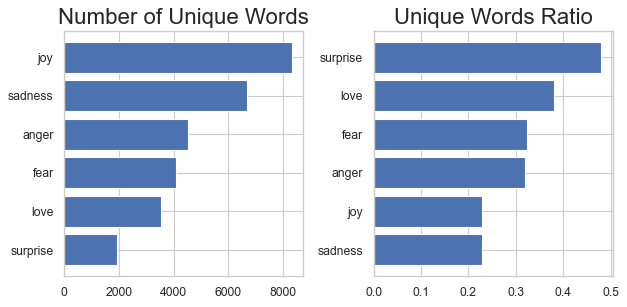

In [53]:
# Let's plot our findings
import numpy as np

figure(figsize=(8, 4), dpi=80)

y_pos = np.arange(len(data_words))

plt.subplot(1, 2, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.feeling)
plt.title('Number of Unique Words', fontsize=20)

plt.subplot(1, 2, 2)
plt.barh(y_pos, data_wpm_sort.unique_ratio, align='center')
plt.yticks(y_pos, data_wpm_sort.feeling)
plt.title('Unique Words Ratio', fontsize=20)

plt.tight_layout()
plt.show()

In [54]:
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

text['polarity'] = text['corpus'].apply(pol)
text['subjectivity'] = text['corpus'].apply(sub)
text

,corpus,polarity,subjectivity
sadness,humiliated hopeless damned hopeful cares awake...,-0.14644,0.64050
anger,grabbing minute post greedy wrong grouchy thin...,-0.15436,0.64861
love,nostalgic fireplace property romantic t let sa...,0.20850,0.66190
surprise,taking milligrams times recommended fallen asl...,0.06722,0.68489
fear,confused life teenager jaded year old man comp...,-0.08197,0.60346
joy,petronas years petronas performed huge profit ...,0.28586,0.65537


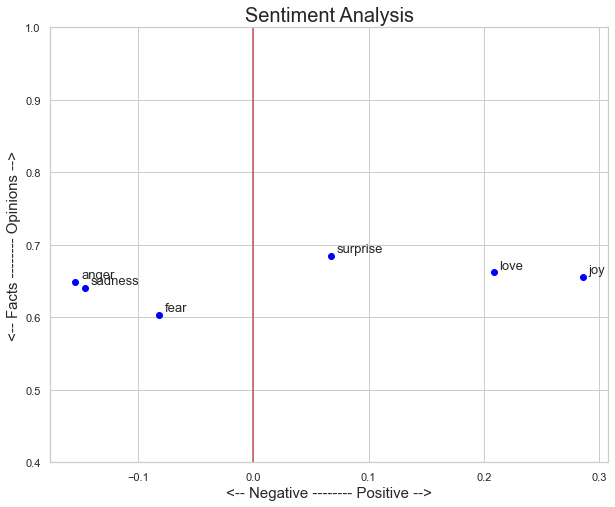

In [88]:
# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, feeling in enumerate(text.index):
    x = text.polarity.loc[feeling]
    y = text.subjectivity.loc[feeling]
    plt.scatter(x, y, color='blue')
    plt.text(x+.005, y+.005, text.index[index], fontsize=13)
    plt.ylim(0.4,1) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
x1, y1 = [0, 0], [0, 1]
plt.plot(x1, y1, c='r')

plt.show()

### Nuevo entrenamiento de modelo